# PM2.5 Statistical Prediction Models_Modeling_6_ARIMA_daily

## Quick Summary

### Key problems:
* How to choose the hyperparameters for the ARIMA and SARIMA models from ACF and PACF plots?<br>
* Why in all cases, the performance on the training set is good but the performance on the test set is very bad? Am I doing anything wrong? <br>
* SARIMA model takes a long time to train for the hourly dataset (at the end of notebook 5) <br>
* Taking the difference to remove trends and un-differencing after the model fitting and predictions alway mess up the data (see notebook 7 and 8 where the target variable is first differenced before applying the ARIMA model) <br>

### Introduction to the notebooks: 
Four notebooks are developed to test out the ARIMA and SARIMA models for various sampling frequencies:
modeling_5_ARIMA_hourly, modeling_6_ARIMA_daily, modeling_7_ARIMA_monthly and modeling_8_ARIMA_diff.<br> 
* (notebook_5) Hourly data: the hourly PM2.5 for Beijing is extracted and both ARIMA model and SARIMA model are attempted. SARIMA model takes a really long time to compute (>1day) so the result is not available.<br> 
* (notebook_6) Daily data: the hourly data is resampled by day and both ARIMA model and SARIMA model are used. <br>
* (notebook_7) Monthly data: the hourly data is resampled by month. Due to the non-stationarity, the monthly data is first transformed towards stationarity by taking the difference, then feed to the ARIMA model. Due to the limited data size in the monthly data, SARIMA is not used. <br>
* (notebook_8): in this notebook, the hourly data is first differenced to remove the underlying trend before feeding to the ARIMA model. The predicted results is then un-differenced to recover to the original scale. <br>

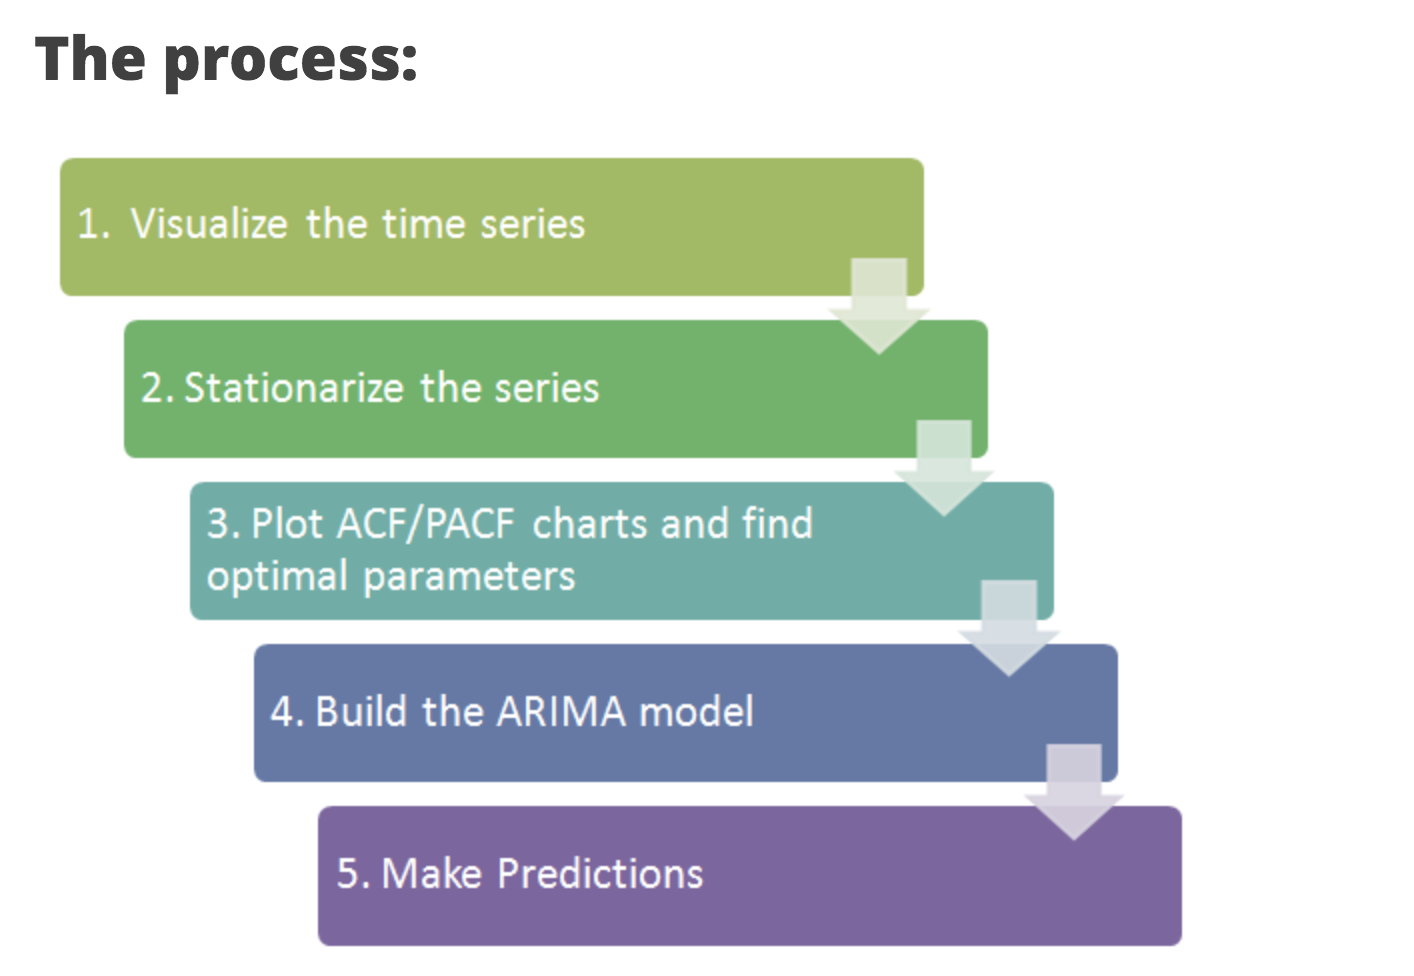

In [59]:
# import relevant module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import pm_clean from 'pm_clean.csv' file and parse the strings in 'date_time' column into DateTime objects

pm_clean = pd.read_csv('pm_clean.csv',index_col=0, parse_dates=['date_time'])
print(pm_clean.head(1))

   year  month  day  hour  season  dewp  humi    pres  temp cbwd   iws  \
0  2010      1    1    23       4 -17.0  41.0  1020.0  -5.0   CV  0.89   

   precipitation  iprec     city  pm_average           date_time    ws  
0            0.0    0.0  beijing       129.0 2010-01-01 23:00:00  0.89  


In [37]:
# use a subset of one city (city Beijing) to explore for now
bj = pm_clean[pm_clean['city'] == 'beijing']

# set 'date_time' as the index and extract 'pm_average' data only
bj_hourly = bj.set_index('date_time')['pm_average']

# resample by day and aggregate using daily average
bj_daily = bj_hourly.resample('D').mean()
bj_daily.dropna(inplace=True)

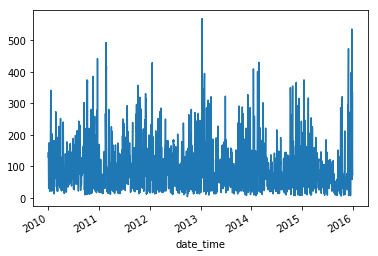

In [33]:
# plot the time series to inspect the features
bj_daily.plot();

As shown, there is a significant seasonality component in the daily time series data.
Need to perform the stationary test to see if there's a need for tranforming the data.

### Test for stationarity
In order to use an ARIMA model, the Dickey-Fuller Test is conducted to determine if the time series is stationary (constant mean, variance and autocorrelation across the time series dataset).
 
<li>$H_o$: Non-stationary series
<li>$H_a$: Stationary series

In [38]:
# http://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.stattools.adfuller.html

useful_values_raw = adfuller(bj_daily, autolag = 'AIC')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%'], 'Value':useful_values})

,Label,Value
0,Test Statistic,-21.577617
1,p-value,0.000000
2,#Lags Used,2.000000
3,Number of Observations Used,2131.000000
4,Critical value for 1%,-3.433422
5,Critical value for 5%,-2.862897
6,Critical value for 10%,-2.567493


p-value is 0.000000, we can reject the null hypothesis of non-stationarity. As the test concludes, the daily pm_average data is already stationary. Therefore, the ARIMA and SARIMA model can be used directly and there is no need for applying the log and difference transformations.

### acf and pacf plots for identifying the model parameters

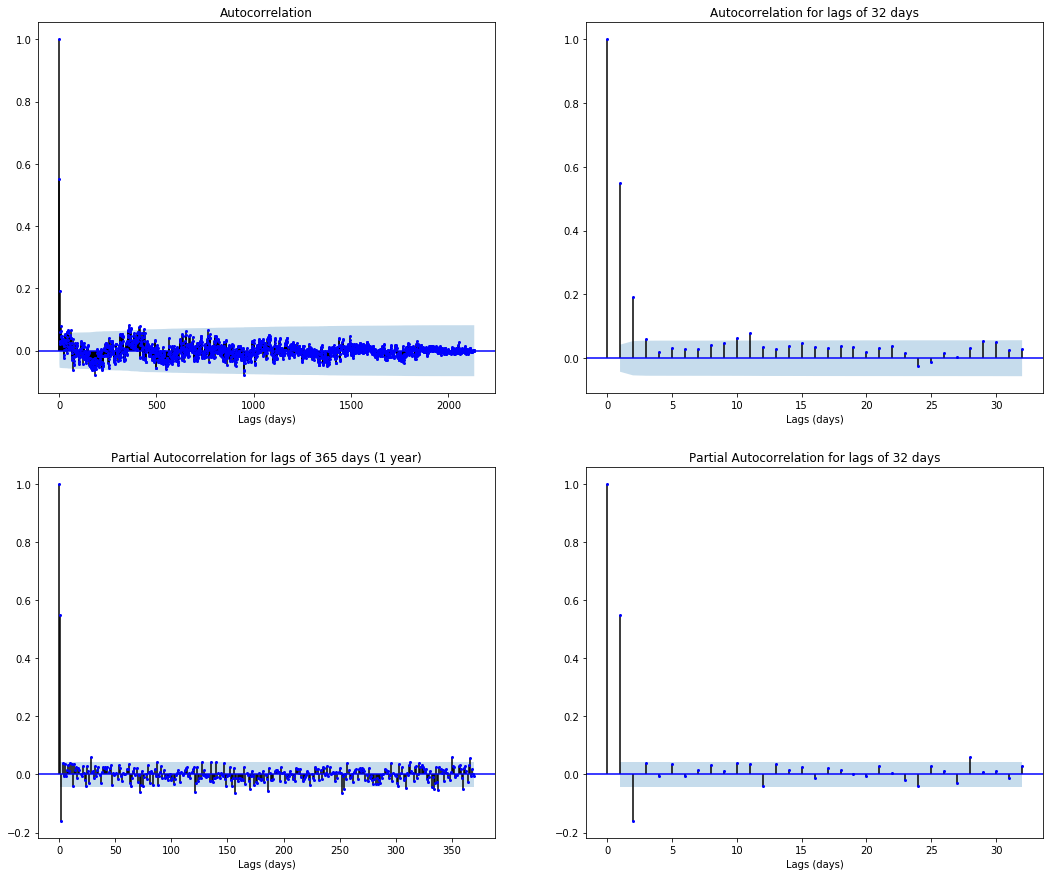

In [36]:
# look at the autocorrelation and partial autocorrelation plots to identify potential structure in the time series data

fig = plt.figure(figsize=(18,15));

ax1 = fig.add_subplot(221)
plot_acf(bj_daily, ax=ax1, color='blue',markersize=2);
ax1.set_xlabel('Lags (days)');

ax2 = fig.add_subplot(222)
plot_acf(bj_daily,lags=32, ax=ax2, title='Autocorrelation for lags of 32 days', color='blue',markersize=2);
ax2.set_xlabel('Lags (days)');

ax3 = fig.add_subplot(223)
plot_pacf(bj_daily, lags=370, ax=ax3, title='Partial Autocorrelation for lags of 365 days (1 year)', color='blue', markersize=2);
ax3.set_xlabel('Lags (days)');

ax4 = fig.add_subplot(224)
plot_pacf(bj_daily, lags=32, ax=ax4, title='Partial Autocorrelation for lags of 32 days', color='blue', markersize=2);
ax4.set_xlabel('Lags (days)');

As the plots and data transformation reveal, the parameters for the ARIMA model should be: 
1. The number of Auto-Regressive Terms based on the pacf plot: p=1 or p=2
2. The number of differences taken given that no data transformation is necessary: d=0
3. The number of Moving Average Terms based on the acf plot: q=1 or q=2

Note: as the plots reveal, there is a somewhat significant yearly seasonality. SARIMA model might help. 

## ARIMA model

In [39]:
# train test split

bj_daily_train = bj_daily.loc['2010':'2014']
bj_daily_test = bj_daily.loc['2015']
print(len(bj_daily_train), len(bj_daily_test))

1788 346


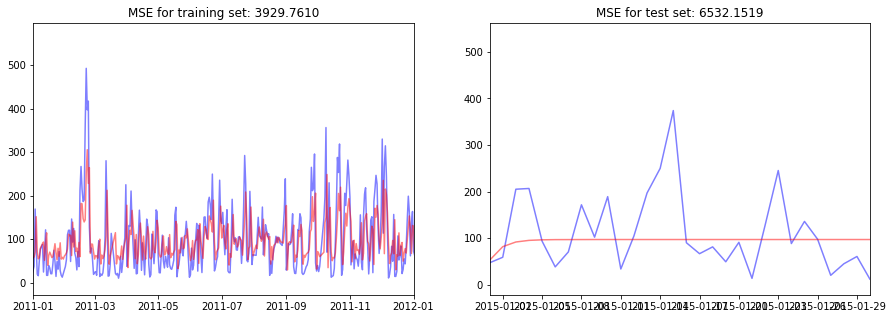

In [60]:
# ARIMA model with p=1, d=0 and q=1
model_1 = ARIMA(bj_daily_train, order=(1, 0, 1))  
result_1 = model_1.fit()
predict_1 = result_1.predict(start=len(bj_daily_train), end=len(bj_daily)-1, dynamic=True)
predict_1.index = bj_daily_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_daily_train, color='blue', alpha=0.5);
ax1.plot(result_1.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_1.fittedvalues-bj_daily_train)**2)));
ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_daily_test, color='blue',alpha=0.5);
ax2.plot(predict_1, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_1-bj_daily_test)**2)));
ax2.set_xlim(['2015-1-1','2015-1-30']);

In [45]:
comparison = pd.DataFrame({'actual':bj_daily_test,'predict':predict_1})
print(comparison.head(20))

                actual    predict
date_time                        
2015-01-01   47.302083  52.771663
2015-01-02   59.152778  81.872779
2015-01-03  205.166667  91.920150
2015-01-04  206.756944  95.389077
2015-01-05   93.673611  96.586749
2015-01-06   38.534722  97.000254
2015-01-07   70.562500  97.143020
2015-01-08  171.739583  97.192311
2015-01-09  102.281250  97.209329
2015-01-10  189.229167  97.215204
2015-01-11   34.000000  97.217233
2015-01-12  104.899306  97.217933
2015-01-13  197.041667  97.218175
2015-01-14  249.906250  97.218259
2015-01-15  373.916667  97.218288
2015-01-16   90.322917  97.218298
2015-01-17   66.833333  97.218301
2015-01-18   81.454861  97.218302
2015-01-19   49.486111  97.218303
2015-01-20   91.166667  97.218303


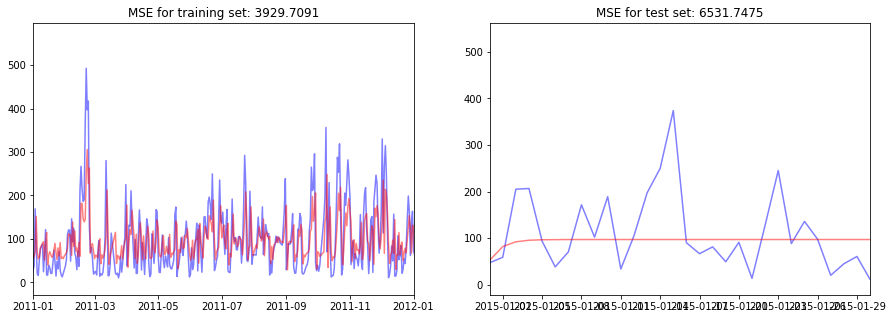

In [61]:
# ARIMA model with p=2, d=0 and q=1

model_2 = ARIMA(bj_daily_train, order=(2, 0, 1))  
result_2 = model_2.fit()
predict_2 = result_2.predict(start=len(bj_daily_train), end=len(bj_daily)-1, dynamic=True)
predict_2.index = bj_daily_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_daily_train, color='blue', alpha=0.5);
ax1.plot(result_2.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_2.fittedvalues-bj_daily_train)**2)));
ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_daily_test, color='blue',alpha=0.5);
ax2.plot(predict_2, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_2-bj_daily_test)**2)));
ax2.set_xlim(['2015-1-1','2015-1-30']);

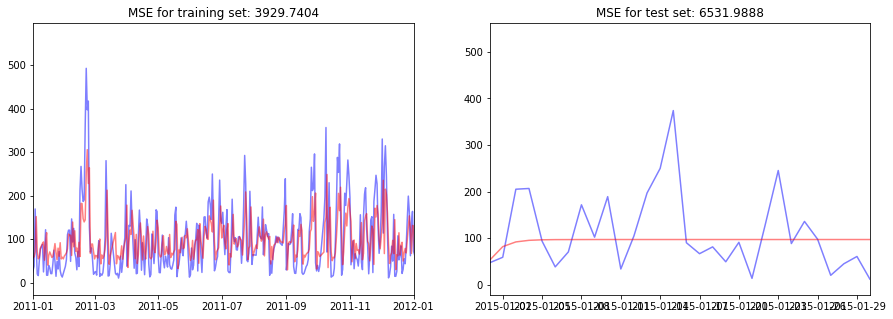

In [62]:
# ARIMA model with p=1, d=0 and q=2

model_3 = ARIMA(bj_daily_train, order=(1, 0, 2))  
result_3 = model_3.fit()
predict_3 = result_3.predict(start=len(bj_daily_train), end=len(bj_daily)-1, dynamic=True)
predict_3.index = bj_daily_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_daily_train, color='blue', alpha=0.5);
ax1.plot(result_3.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_3.fittedvalues-bj_daily_train)**2)));
ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_daily_test, color='blue',alpha=0.5);
ax2.plot(predict_3, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_3-bj_daily_test)**2)));
ax2.set_xlim(['2015-1-1','2015-1-30']);

                              ARMA Model Results                              
Dep. Variable:             pm_average   No. Observations:                 1788
Model:                     ARMA(2, 2)   Log Likelihood               -9936.158
Method:                       css-mle   S.D. of innovations             62.682
Date:                Tue, 11 Sep 2018   AIC                          19884.316
Time:                        14:01:04   BIC                          19917.249
Sample:                             0   HQIC                         19896.477
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               97.2188      2.891     33.625      0.000      91.552     102.886
ar.L1.pm_average     0.7256      0.609      1.192      0.233      -0.467       1.918
ar.L2.pm_average    -0.1480 

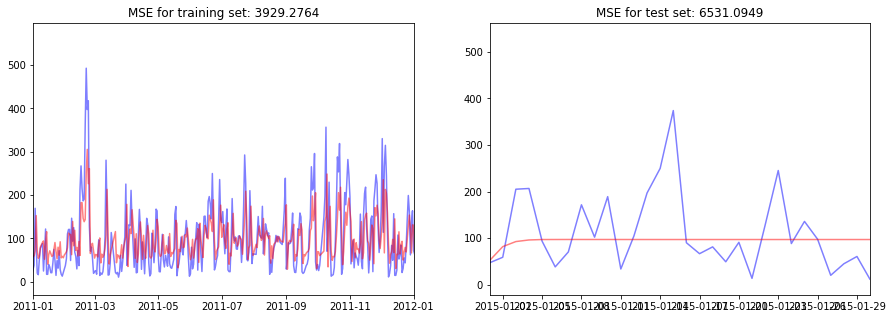

In [72]:
# ARIMA model with p=2, d=0 and q=2

model_4 = ARIMA(bj_daily_train, order=(2, 0, 2))  
result_4 = model_4.fit()
predict_4 = result_4.predict(start=len(bj_daily_train), end=len(bj_daily)-1, dynamic=True)
predict_4.index = bj_daily_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_daily_train, color='blue', alpha=0.5);
ax1.plot(result_4.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_4.fittedvalues-bj_daily_train)**2)));
ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_daily_test, color='blue',alpha=0.5);
ax2.plot(predict_4, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_4-bj_daily_test)**2)));
ax2.set_xlim(['2015-1-1','2015-1-30']);

print(result_4.summary())

In general, four ARIMA models with various p,d,q combinations share similar performances, with great performance on the training set but very poor performance on the test set.

## SARIMA model

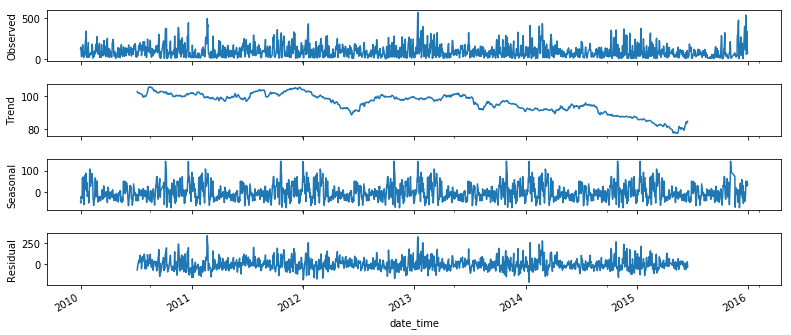

In [64]:
# decomposition
decomposition = seasonal_decompose(bj_daily, freq=365) # freq = 1 year
fig = decomposition.plot()
fig.set_size_inches(12, 5);

# # access each component of the decomposition 
# trend = decomposition.trend
# seasonal = decomposition.seasonal 
# residual = decomposition.resid

Decomposition with a frequency of one-year reveals a pronounced seasonality and a downward trend.

                                  Statespace Model Results                                 
Dep. Variable:                          pm_average   No. Observations:                 1788
Model:             SARIMAX(1, 0, 1)x(0, 1, 0, 365)   Log Likelihood               -8412.518
Date:                             Tue, 11 Sep 2018   AIC                          16831.036
Time:                                     12:53:38   BIC                          16846.818
Sample:                                          0   HQIC                         16836.931
                                            - 1788                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2700      0.037      7.368      0.000       0.198       0.342
ma.L1          0.3475      

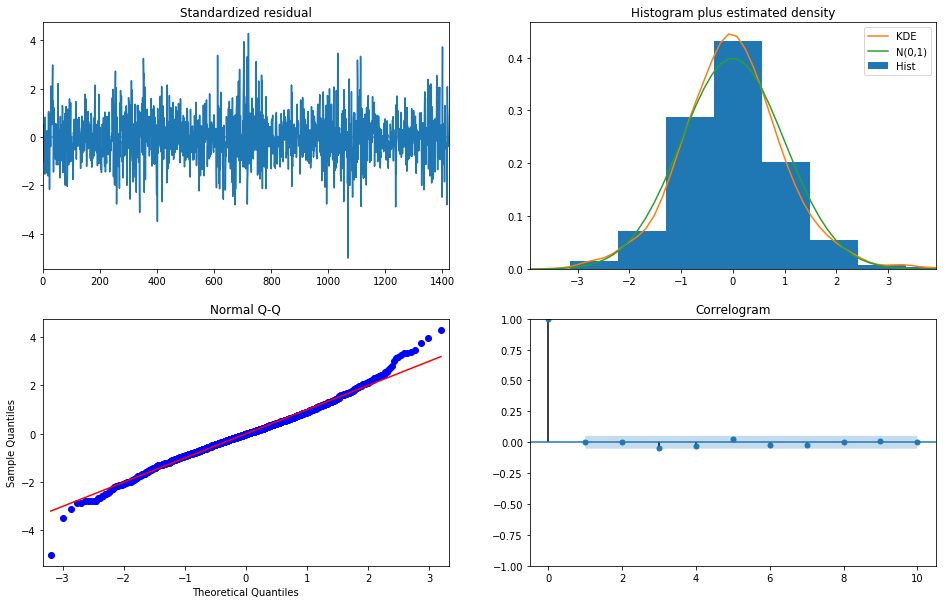

In [67]:
model_5 = SARIMAX(bj_daily_train, order=(1,0,1), seasonal_order=(0,1,0,365))
result_5 = model_5.fit()
print(result_5.summary());
result_5.plot_diagnostics(figsize=(16,10));

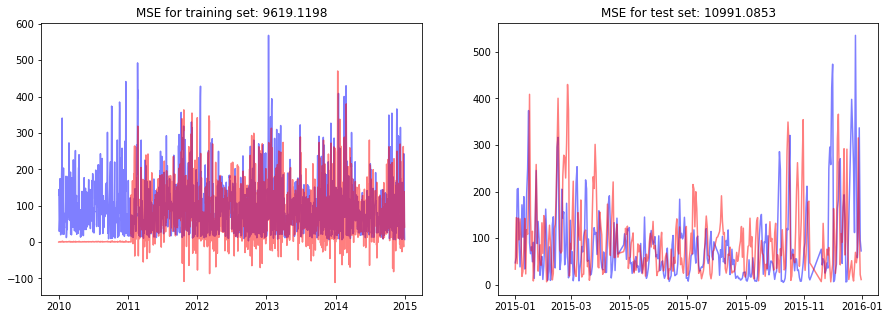

In [70]:
predict_5 = result_5.predict(start=len(bj_daily_train), end=len(bj_daily)-1, dynamic=True)
predict_5.index = bj_daily_test.index

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(bj_daily_train, color='blue', alpha=0.5);
ax1.plot(result_5.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.4f}'.format(np.mean((result_5.fittedvalues-bj_daily_train)**2)));
#ax1.set_xlim(['2011','2012']);

ax2 = fig.add_subplot(122)
ax2.plot(bj_daily_test, color='blue',alpha=0.5);
ax2.plot(predict_5, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.4f}'.format(np.mean((predict_5-bj_daily_test)**2)));
#ax2.set_xlim(['2015-1-1','2015-1-5']);